# Manipulating fMRI data and computing a connectome

## Loading the data

For this tutorial, we will use the data provided by the `nilearn.datasets` module.
We first download some fMRI data from 1 subject

In [3]:
from nilearn import datasets
import os

data_dir = os.path.join('..', 'data','connectivity') # change this variable with the path where you want nilearn to download
                # the data, if you leave None, the default will be '~/nilearn_data'
    
# Loading the functional datasets
data = datasets.fetch_development_fmri(n_subjects=1, data_dir=data_dir)

# you can use the .keys() method to check what's in the dataset
data.keys()


Added README.md to ../data/connectivity


Dataset created in ../data/connectivity/development_fmri


Added README.md to ../data/connectivity/development_fmri


Dataset created in ../data/connectivity/development_fmri/development_fmri



 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (2 seconds, 0 min)


dict_keys(['func', 'confounds', 'phenotypic', 'description'])

In [4]:
# We can check the description of the dataset to know what we're dealing with 
print(data.description)

.. _development_dataset:

development fMRI dataset

Access
------
See :func:`nilearn.datasets.fetch_development_fmri`.

Notes
-----
This movie-watching based functional MRI dataset is used for teaching how to use
machine learning to predict age from naturalistic stimuli (movie)
watching with Nilearn.

The dataset consists of 50 children (ages 3-13) and 33 young adults (ages
18-39). This dataset can be used to try to predict who are adults and
who are children.

The data is downsampled to 4mm resolution for convenience. The original
data is downloaded from OpenNeuro.

For full information about pre-processing steps on raw-fMRI data, have a look
at README at https://osf.io/wjtyq/

Full pre-processed data: https://osf.io/5hju4/files/

Raw data can be accessed from : https://openneuro.org/datasets/ds000228/versions/1.0.0

See :footcite:t:`Richardson2018`.

Content
-------
    :'func': functional MRI Nifti images (4D) per subject
    :'confounds': TSV file contain nuisance information per s

In [5]:
# data.func contains the paths to the Nifti files (the files containing fMRI data)
fmri_filepath = data.func[0]
print(fmri_filepath)

../data/connectivity/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


In [13]:
# We can load a Nifti file with the nibabel library
import nibabel as nib

fmri_img = nib.load(fmri_filepath)
print(fmri_img)


<class 'nibabel.nifti1.Nifti1Image'>
data shape (50, 59, 50, 168)
affine:
[[   4.    0.    0.  -96.]
 [   0.    4.    0. -132.]
 [   0.    0.    4.  -78.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  4  50  59  50 168   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 4. 4. 4. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : align

So this is a `Nifti1Image` object which contains 3 things :
* some data of shape (50, 59, 50, 168)
* an affine array that defines the spatial orientation and scale of the data
* a header, containing more information about the data format

Note that the data is a 4D array. The last dimension is the time, so we have 168 volumes, and from the 5th value of the pixdim array in the header we can see that the t_r is 1s, so we have a file that represents 168s of scanning. 

For each time point we have a 3D array that contains the voxels. But not all these voxels correspond to the brain.

In [14]:
# let's get the data array 
fmri_data = fmri_img.get_fdata()
fmri_data.shape

(50, 59, 50, 168)

We can choose a voxel (for example the one with coordinates 25, 30, 25) and plot its time series :

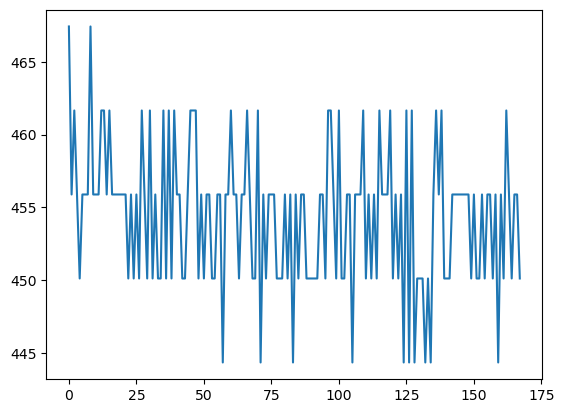

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(fmri_data[25,30,25])

We can also plot a slice of our brain for a time point as an image, for example a transversal slice for the first time point and z=25 : 

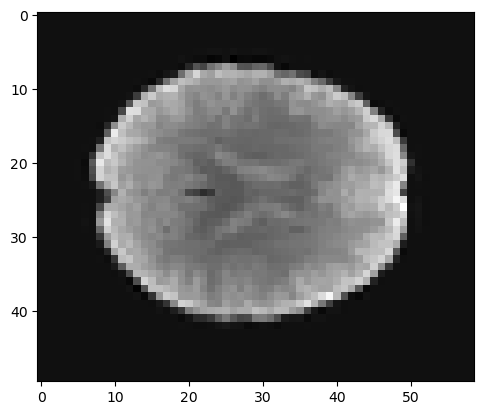

In [16]:
plt.imshow(fmri_data[:,:,25,0], cmap='gray')

Here all the black pixels in our image are voxels present in our `fmri_data` array but not containing any brain. Thus we want to exclude all these empty voxels just to keep the ones containing brain data. To do that we're gonna use a **masker**. 

## Masking the data

The masker not only removes the background voxels, but it can also regress out the confounds if you provide them.

In short, the confounds are external sources of signal you want to remove, such as the movement of the head. Regressing out the confounds means removing the part of the signal correlated to the sources of noise. For example we can remove the part of the signal that correlates with the head motion because we consider this part of signal to be only artefacts caused by the movements and not relevant for brain activity. 

Confounds handling is in reality more complicated than that, if you want to learn more you can check the [fMRIprep documentation](https://fmriprep.org/en/stable/outputs.html#confounds).

In [60]:
from nilearn.input_data import NiftiMasker

masker = NiftiMasker()
masked_data = masker.fit_transform(fmri_filepath, confounds=data.confounds)
masked_data.shape

(168, 32504)

Now you see that our array has a different shape, we have our time dimension first with still 168 time points, but for each time point, instead of a 3D volume, we have a 1D array. 

Also note that we kept 32,504 voxels, when whe had a total of 50\*59*50 = 147,500, so we got rid of a lot of empty voxels. That is good, but the downside is that we lost the spatial information of where these voxels are in the brain. But don't worry because the masker remembers it. If we want to recover this information and turn back our 1D arrays into 3D spatial ones we can uste the `makser.inverse_transform` method.

For example if we want to threshold our fMRI data by the mean and then plot ther result we can do it this way :

In [18]:
masked_data.mean()

424.19533931161124

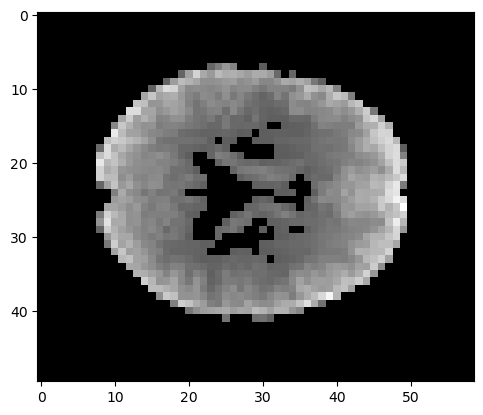

In [19]:
thresholded_masked_data = masked_data * (masked_data > masked_data.mean())

'''
masked_data > masked_data.mean()：这部分代码产生一个布尔数组，其中所有高于 masked_data 数组均值的元素被标记为 True，低于或等于均值的元素被标记为 False。
masked_data * (masked_data > masked_data.mean())：这部分将原始的 masked_data 数组与上述布尔数组相乘。在布尔数组中，True 值为 1，False 值为 0。
因此，这一操作的结果是将所有低于或等于均值的数据点置为 0，只保留高于均值的数据点。
'''

thresholded_img = masker.inverse_transform(thresholded_masked_data)

'''
将处理后的数据（这里是阈值化后的数据）从压缩或特征选择的空间映射回原始的三维或四维神经影像空间。
'''

plt.imshow(thresholded_img.get_fdata()[:,:,25,0], cmap='gray')
'''
thresholded_img.get_fdata()：这一调用提取了 Nifti 图像对象中的数据。get_fdata() 方法通常用于获取浮点数形式的数据。
[:,:,25,0]：这部分是一个数组切片操作，用于选择特定的二维切片。
plt.imshow(..., cmap='gray')：使用 matplotlib 的 imshow 函数将选定的二维切片显示为图像，使用灰度色图显示。这样可以可视化特定脑层在阈值化处理后的活动情况。
'''

In [33]:
masked_data

array([[ 5.26590872,  5.26590872,  5.26590872, ..., -6.28832579,
        -1.28026842, -6.28832579],
       [ 5.26590872,  5.26590872,  5.26590872, ..., -6.28832579,
        -3.02182673, -6.28832579],
       [ 5.26590872,  5.26590872,  5.26590872, ..., -6.28832579,
        -1.5626807 , -6.28832579],
       ...,
       [ 5.26590872,  5.26590872,  5.26590872, ..., -6.28832579,
         1.19529513, -6.28832579],
       [ 5.26590872,  5.26590872,  5.26590872, ..., -6.28832579,
        -0.07993331, -6.28832579],
       [ 5.26590872,  5.26590872,  5.26590872, ..., -6.28832579,
        -0.97345288, -6.28832579]])

In [34]:
masked_data > masked_data.mean()

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [39]:
thresholded_masked_data

array([[ 0.,  0.,  0., ..., -0., -0., -0.],
       [ 0.,  0.,  0., ..., -0., -0., -0.],
       [ 0.,  0.,  0., ..., -0., -0., -0.],
       ...,
       [ 0.,  0.,  0., ..., -0.,  0., -0.],
       [ 0.,  0.,  0., ..., -0., -0., -0.],
       [ 0.,  0.,  0., ..., -0., -0., -0.]])

In [68]:
thresholded_masked_data.shape

(168, 32504)

In [25]:
thresholded_img

**NOTE**: In this example we instantiated a `NiftiMasker` without providing any argument, 
however depending on the data used, we might want to use specific strategies to remove the
background voxels, and we can ask the masker to do some complementrary processing such as 
standardizing the data, deterending it or resampleing it. In real-life use cases you should carefully 
choose the arguments to provide to the `NiftiMasker`. These arguments are explained in 
the [nilearn documentation](https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html).

## Using an atlas

Having removed the empty voxels is great, and we could directly compute a connectome on the masked data,
but it would create a 32,504 by 32,504 matrix, which would be a bit hard to analyse.

An easier way to manipulate the data would be to use an atlas, that defines region of interest (ROIs). We could create our own atlas by clustering the voxels, but hopefully nilearn provides ready-made atlases, let's load one.

In [40]:
atlas_dataset = datasets.fetch_atlas_msdl(data_dir=data_dir)
atlas_filepath = atlas_dataset.maps
labels = atlas_dataset.labels


Dataset created in ../data/connectivity/msdl_atlas



 ...done. (2 seconds, 0 min)
Extracting data from ../data/connectivity/msdl_atlas/8eaecb9e05c478f565847000d9902a25/MSDL_rois.zip..... done.


We now have the path to the Nifti file containing the ROIs info in `atlas_filepath` and the names of the ROIs in `labels`.

To apply the atlas on our data, we can once again use a masker, bu this time a `NiftiMapsMasker`.

In [41]:
from nilearn.input_data import NiftiMapsMasker

atlas_masker = NiftiMapsMasker(maps_img=atlas_filepath, standardize=True)

data_in_atlas = atlas_masker.fit_transform(fmri_filepath, confounds=data.confounds)
data_in_atlas.shape

(168, 39)

We see that now we only have 39 values per time point, so we have 39 ROIs. This is more appropriate to compute a connectivity matrix.

We can plot the time series in a ROI (for example the 5th one) :

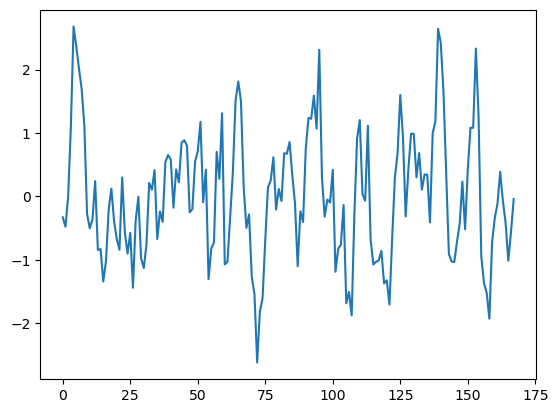

In [42]:
plt.plot(data_in_atlas[:,4])

**Note**: Depending on the type of atlas you use, you might have to use different kinds of masker. Here we have probabilistic overlapping regions, so we use a `NiftiMapsMasker`, but if we had non-overlapping regions, we would use a `NiftiLabelsMasker`.

## Connectome

Let's compute and plot a correlation matrix !

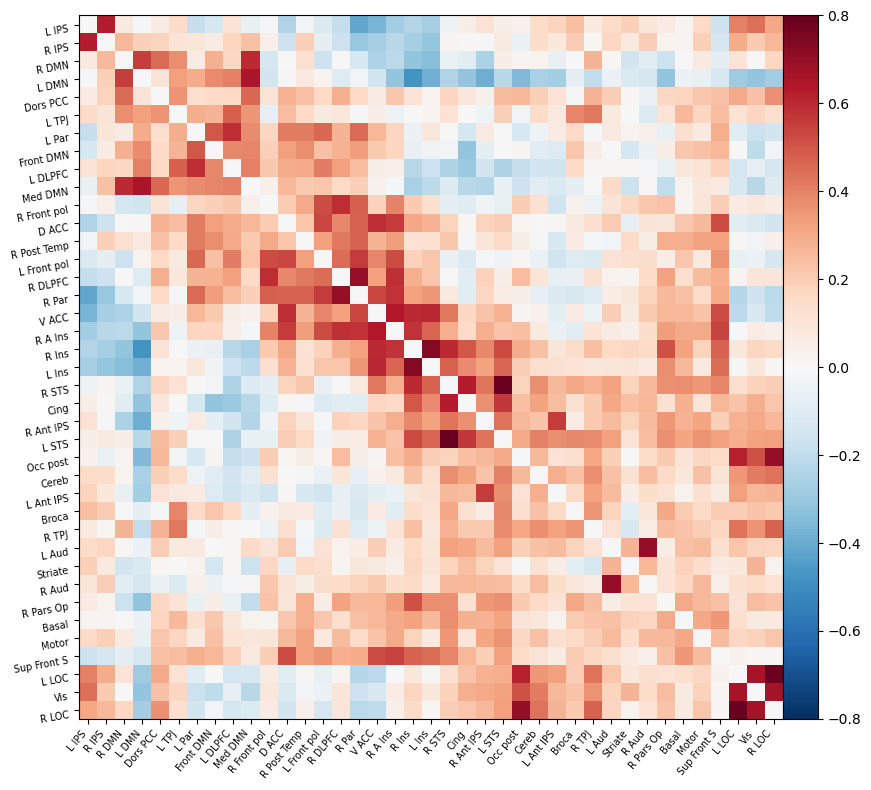

In [44]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([data_in_atlas])[0]

# Plot the correlation matrix
import numpy as np
from nilearn import plotting
# Make a large figure
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)
# The matrix is reordered for block-like representation
plotting.plot_matrix(correlation_matrix, figure=(10, 8), labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=True)

In [46]:
correlation_matrix

array([[0.        , 0.7034669 , 0.27146001, ..., 0.16152248, 0.25084919,
        0.25541097],
       [0.7034669 , 0.        , 0.26331555, ..., 0.1553671 , 0.13864582,
        0.25356842],
       [0.27146001, 0.26331555, 0.        , ..., 0.16527361, 0.06122733,
        0.17540062],
       ...,
       [0.16152248, 0.1553671 , 0.16527361, ..., 0.        , 0.09422716,
        0.38453826],
       [0.25084919, 0.13864582, 0.06122733, ..., 0.09422716, 0.        ,
        0.55657205],
       [0.25541097, 0.25356842, 0.17540062, ..., 0.38453826, 0.55657205,
        0.        ]])

In [47]:
labels

['L Aud',
 'R Aud',
 'Striate',
 'L DMN',
 'Med DMN',
 'Front DMN',
 'R DMN',
 'Occ post',
 'Motor',
 'R DLPFC',
 'R Front pol',
 'R Par',
 'R Post Temp',
 'Basal',
 'L Par',
 'L DLPFC',
 'L Front pol',
 'L IPS',
 'R IPS',
 'L LOC',
 'Vis',
 'R LOC',
 'D ACC',
 'V ACC',
 'R A Ins',
 'L STS',
 'R STS',
 'L TPJ',
 'Broca',
 'Sup Front S',
 'R TPJ',
 'R Pars Op',
 'Cereb',
 'Dors PCC',
 'L Ins',
 'Cing',
 'R Ins',
 'L Ant IPS',
 'R Ant IPS']

## Plotting

Earlier we simply plotted a slice of our brain with matplotlib. It works and it is a fine way to check your data array. However for more complex or fancy plots, nilearn comes with a lot of handy tools in its `nilearn.plotting` module. Here are a few examples.

* To view a 3D NiftiImage object, the `view_img` functions makes it easy to interactively go through the slices.

/Users/xuan/anaconda3/envs/tuto/lib/python3.8/site-packages/nilearn/plotting/html_stat_map.py:112: UserWarning: Threshold given was 1e-06, but the data has no values below -116.0191650390625. 
  warnings.warn(
/Users/xuan/anaconda3/envs/tuto/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



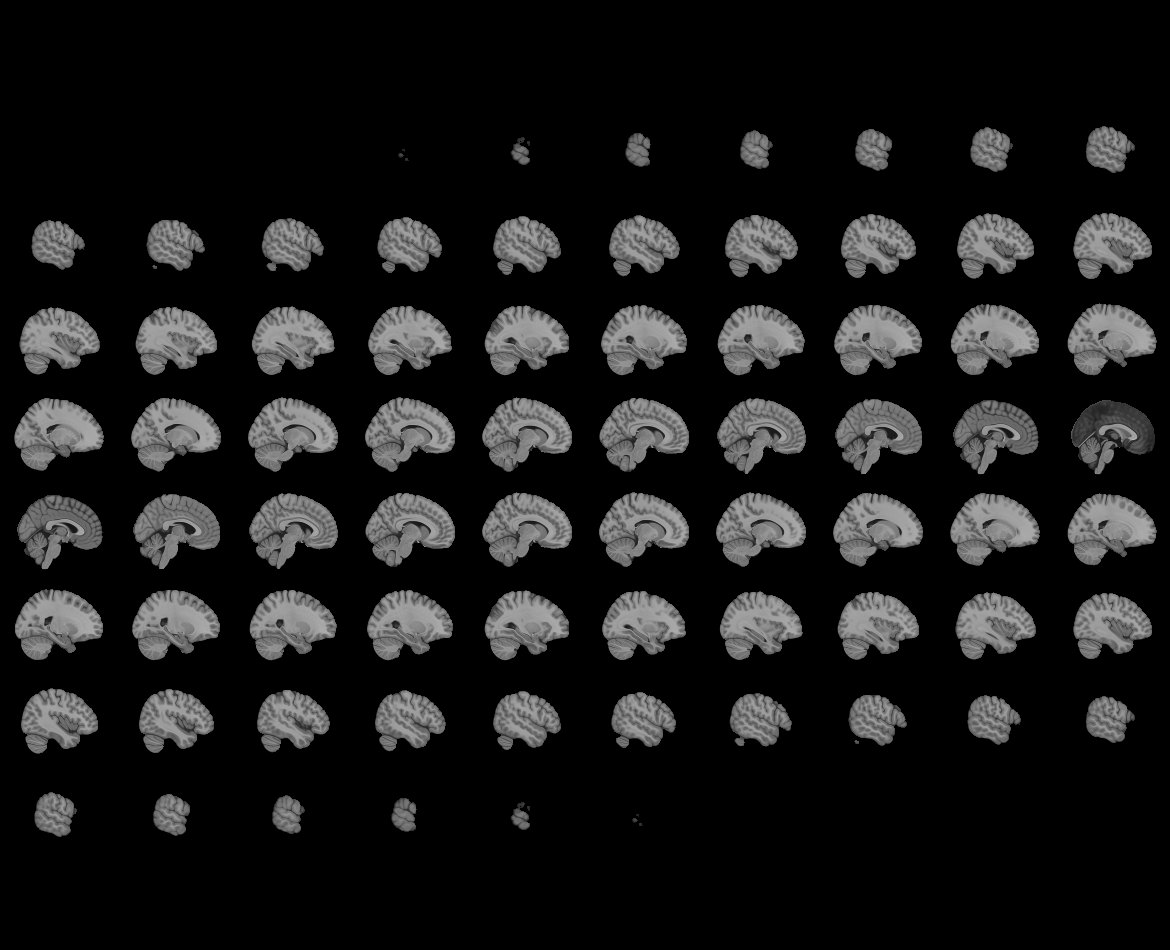
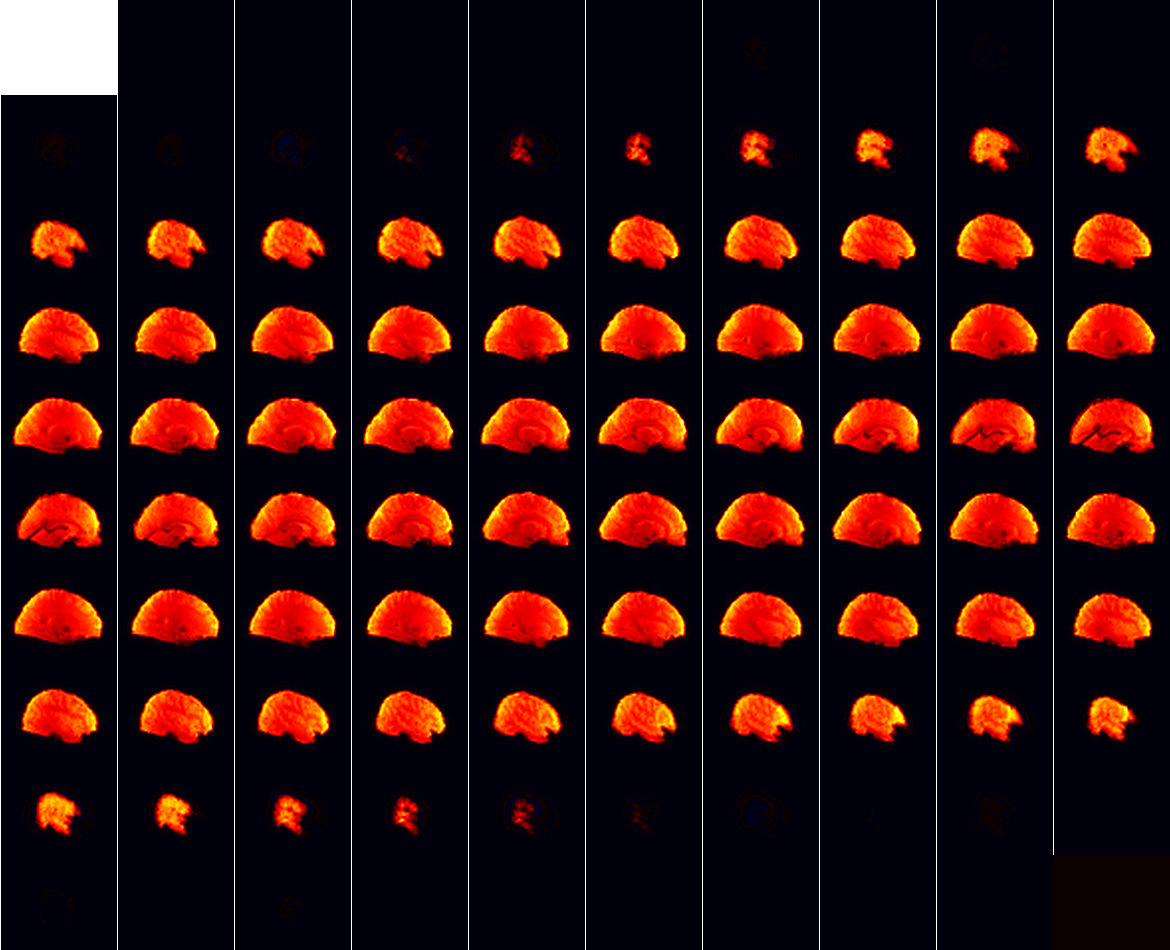

In [73]:
from nilearn.plotting import view_img

# Since our fmri_img is a 4D NiftiImage, we need to generate a 3D one.
# One way of doing that is averaging our volumes on the time axis 
# with the mean_img function.
from nilearn.image.image import mean_img

fmri_img_mean = mean_img(fmri_img)
view_img(fmri_img_mean)

In [72]:
fmri_img_mean.shape

(50, 59, 50)

* To display the graph corresponding to a connectome, you can use `plot_connectome`.

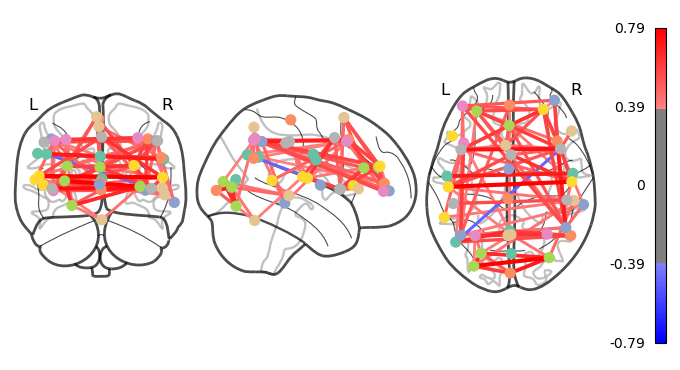

In [53]:
from nilearn.plotting import plot_connectome

coords = atlas_dataset.region_coords

# We threshold to keep only the 10% of edges with the highest value
# because the graph is very dense
plot_connectome(correlation_matrix, coords,
                edge_threshold="90%", colorbar=True)
# edge_threshold="90%"用于确定哪些边（连接）将被包括在图中，去除图中的冗余连接，使得重要的连接更加突出

In [59]:
print('length of coords:',len(coords))
coords

length of coords: 39


[[-53.28, -8.88, 32.36],
 [53.47, -6.49, 27.52],
 [1.18, -74.54, 10.79],
 [-45.8, -64.78, 31.84],
 [-0.2, -55.21, 29.87],
 [-0.15, 51.42, 7.58],
 [51.66, -59.34, 28.88],
 [0.41, -91.05, 1.58],
 [-1.48, -27.93, 61.5],
 [40.1, 20.96, 44.72],
 [37.83, 55.49, 1.22],
 [47.53, -52.42, 43.06],
 [62.53, -32.99, -9.14],
 [-0.91, -2.75, 6.15],
 [-41.66, -59.04, 44.61],
 [-39.04, 19.28, 43.27],
 [-40.08, 50.65, 0.81],
 [-29.39, -59.43, 44.2],
 [31.6, -58.09, 45.69],
 [-30.54, -85.14, 9.1],
 [-24.29, -74.28, -11.74],
 [33.4, -77.96, 4.31],
 [-28.17, 46.32, 21.56],
 [-0.45, 34.06, 20.73],
 [28.38, 47.72, 22.13],
 [-52.12, -17.92, 13.28],
 [52.61, -13.65, 12.11],
 [-55.52, -43.77, 10.08],
 [-48.66, 25.11, 5.7],
 [-3.39, 17.19, 63.52],
 [54.42, -29.5, -2.72],
 [52.38, 29.39, 2.93],
 [1.05, -58.49, -23.91],
 [-1.44, -59.12, 55.25],
 [-41.33, 13.63, 2.7],
 [1.05, 9.2, 46.43],
 [43.01, 14.3, 2.79],
 [-47.85, -32.07, 41.9],
 [48.36, -29.04, 43.13]]

To discover more ways of generating super cool visuals of brains, check the [nilearn plotting documentation](https://nilearn.github.io/plotting/index.html).

# Exercises

## 1. Of the importance of confounds

* Generate a correlation matrix with the same data, but this time without using the confounds when masking.

How does that impact the correlation matrix ?
Why do you think it affects the matrix this way ?

* Plot the obtained connectome in 3D using `nilearn.plotting.view_connectome` (check [the doc](https://nilearn.github.io/modules/generated/nilearn.plotting.view_connectome.html) to know how to use it).

In [63]:
from nilearn.input_data import NiftiMasker

masker2 = NiftiMasker()
masked_data2 = masker2.fit_transform(fmri_filepath)
masked_data2.shape

(168, 32504)

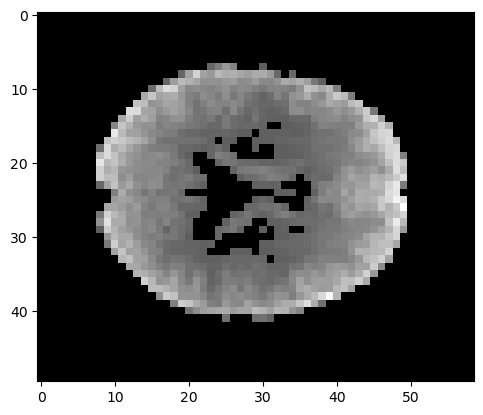

In [64]:
thresholded_masked_data2 = masked_data2 * (masked_data2 > masked_data2.mean())


thresholded_img2 = masker2.inverse_transform(thresholded_masked_data2)

plt.imshow(thresholded_img2.get_fdata()[:,:,25,0], cmap='gray')

In [65]:
atlas_masker2 = NiftiMapsMasker(maps_img=atlas_filepath, standardize=True)

data_in_atlas2 = atlas_masker2.fit_transform(fmri_filepath)
data_in_atlas2.shape

(168, 39)

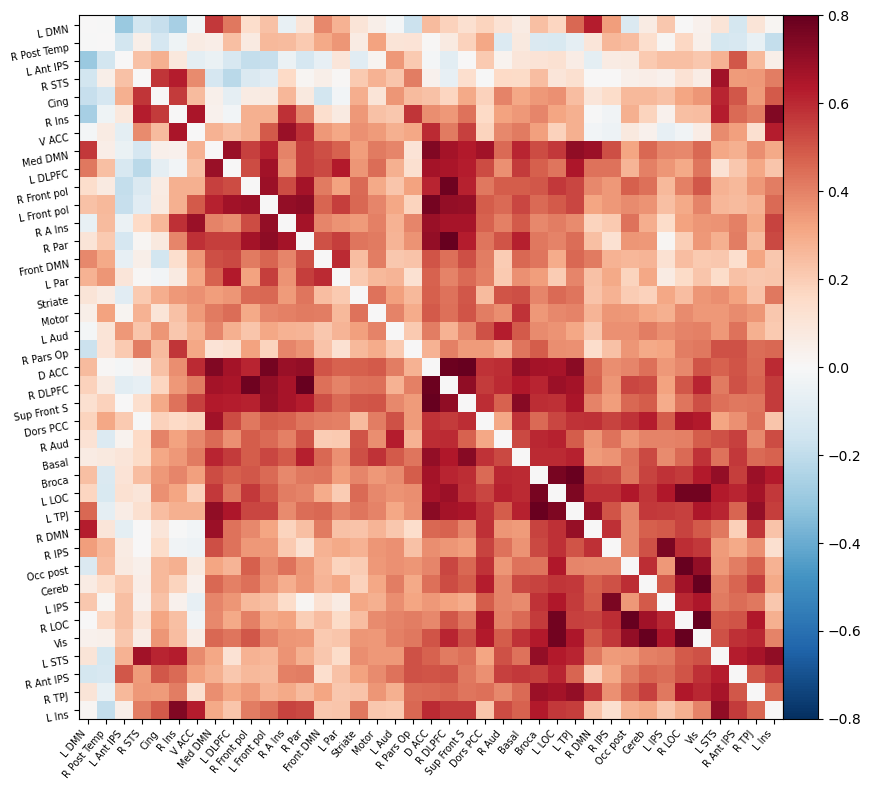

In [66]:
correlation_measure2 = ConnectivityMeasure(kind='correlation')
correlation_matrix2 = correlation_measure2.fit_transform([data_in_atlas2])[0]

np.fill_diagonal(correlation_matrix2, 0)

plotting.plot_matrix(correlation_matrix2, figure=(10, 8), labels=labels,
                     vmax=0.8, vmin=-0.8, reorder=True)

## 2. Visualizing the atlas and a specific time point

* Use `view_img` to visualize the 5th ROI of the atlas. (Hint: use the atlas masker to inverse transform an array with 1 at the index 4 and 0 every where else.)

* Use `plotting.plot_prob_atlas` to show all the ROIs with filled contours. (Hint: check the nilearn documentation to see how to use `plotting.plot_prob_atlas`).
* Earlier we used `view_img` to plot the mean volume of our `fmri_img` data because `view_img` doesn't accept 4D images but only 3D ones. Find a way to generate a 3D Nifti image with the 84th time point in `fmri_img` and plot it with `view_img`.

In [78]:
data_in_atlas

array([[-1.14709094, -0.71591096, -3.46818971, ..., -0.15243065,
        -1.35813221, -0.29328667],
       [-0.46540721,  0.29085566, -0.54325373, ...,  0.07522578,
        -0.3300142 , -0.130604  ],
       [ 0.76139007,  0.31099433,  0.87814575, ..., -1.09592792,
         0.04716267, -0.78159385],
       ...,
       [ 0.15710528,  0.4949099 ,  2.90774426, ..., -0.13585334,
         0.89035429, -0.20358845],
       [ 0.16853284,  1.72995705,  1.29821615, ..., -1.27216112,
         0.40988543, -0.27027007],
       [ 2.20099085,  3.41367418,  1.18886392, ..., -0.13074281,
        -1.53771922, -0.06383788]])

In [84]:
roi_img2.shape

(40, 48, 35, 168)

In [93]:
roi_img2.slicer[:, :, :, 0].shape

(40, 48, 35)

/Users/xuan/anaconda3/envs/tuto/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



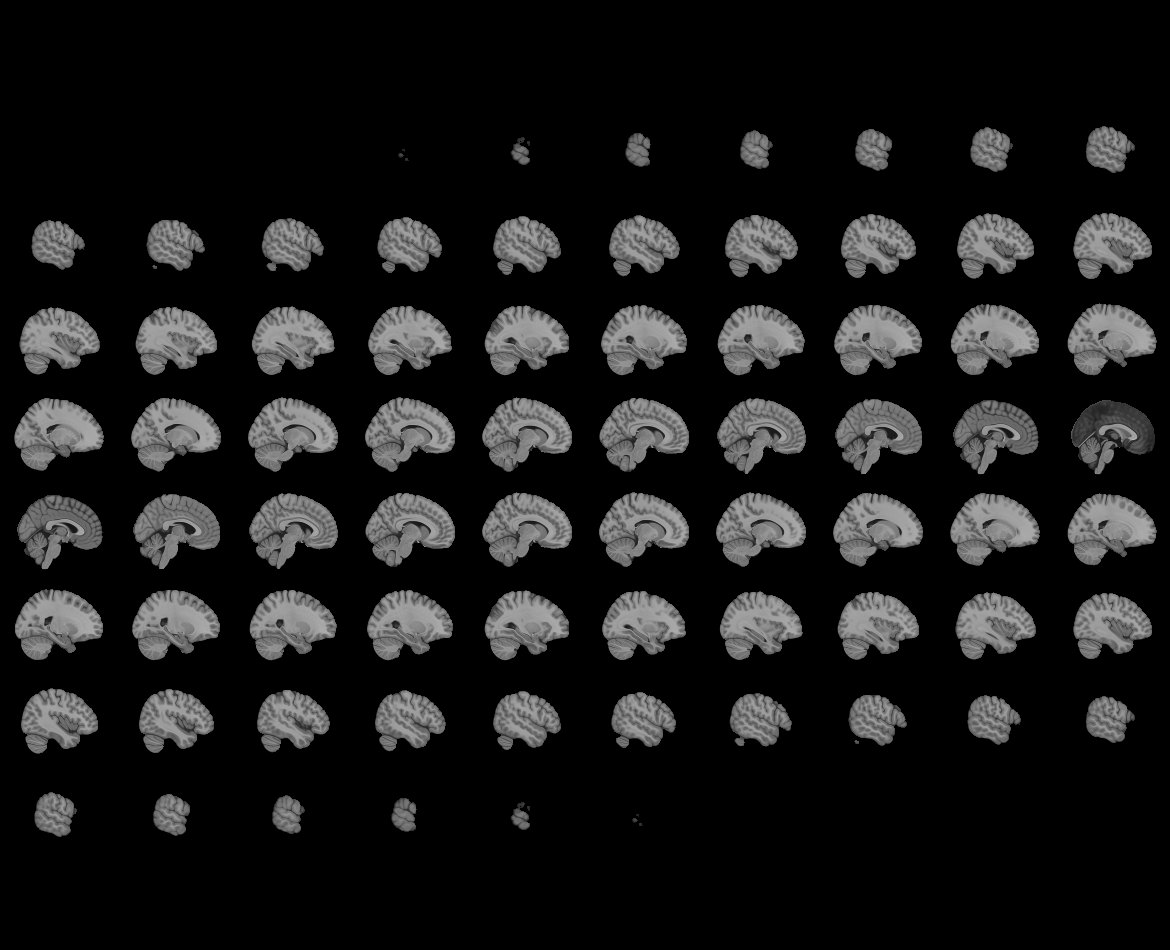
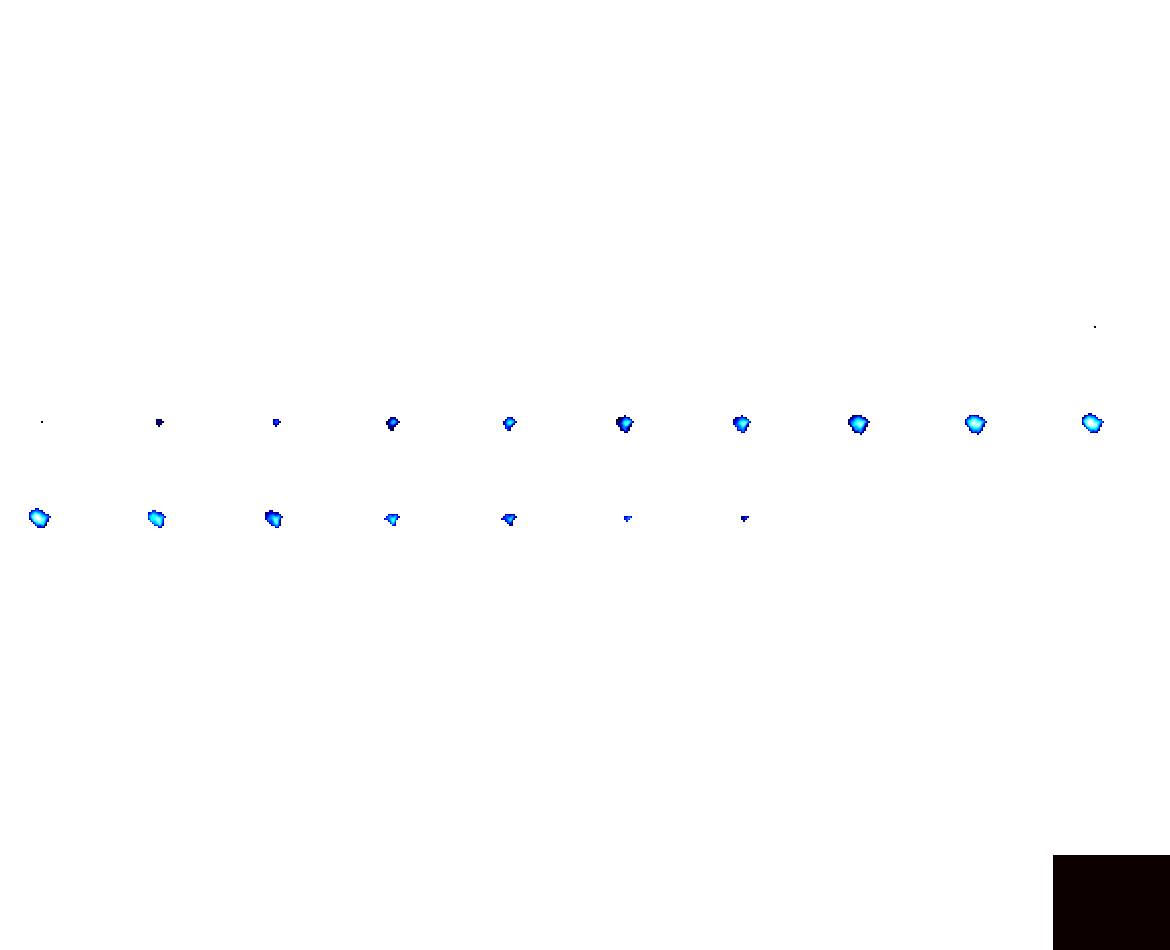

In [94]:
zero_data = np.zeros_like(data_in_atlas)

zero_data[:, 4] = data_in_atlas[:, 4]

roi_img2 = atlas_masker.inverse_transform(zero_data)

view_img(roi_img2.slicer[:, :, :, 0],  title="5th ROI of the Atlas")

In [79]:
data_in_atlas.shape[0]

168

/Users/xuan/anaconda3/envs/tuto/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



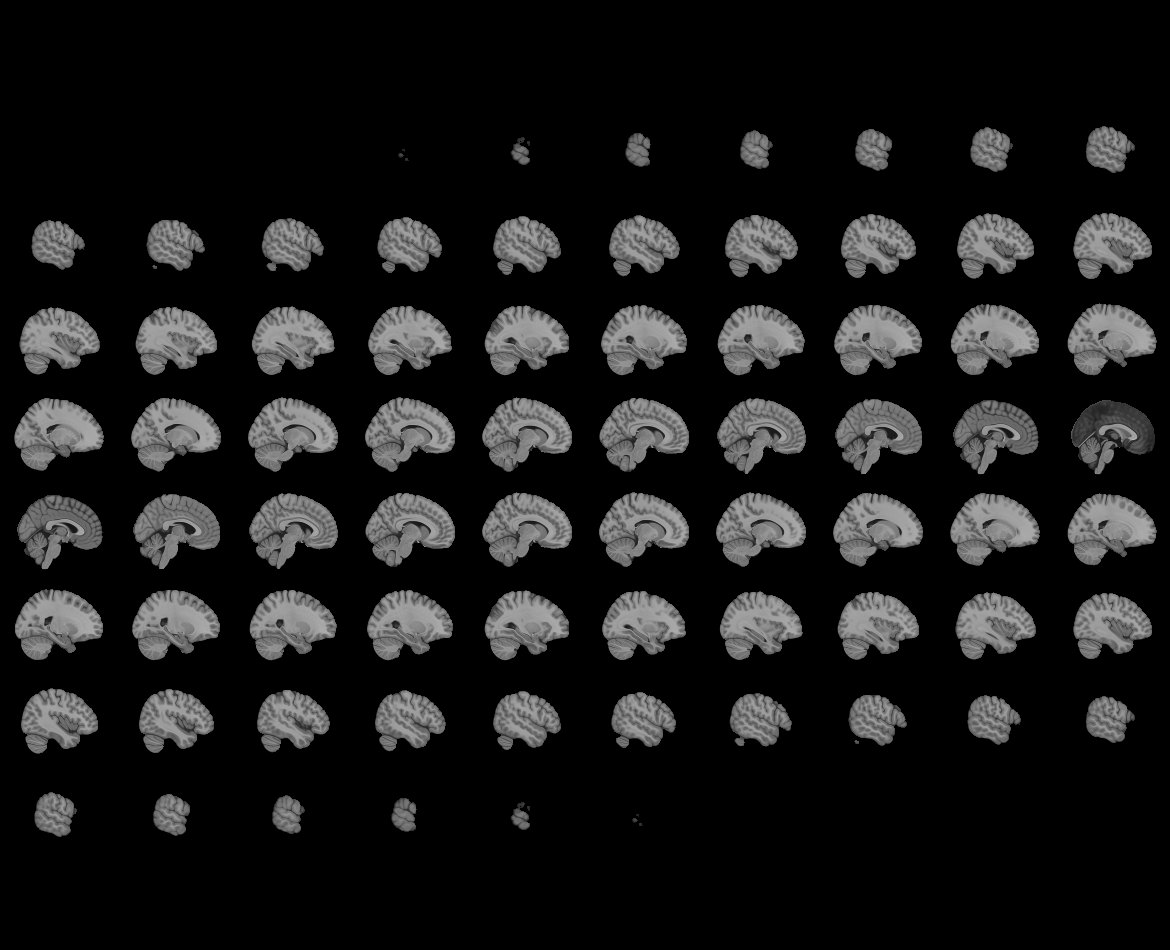
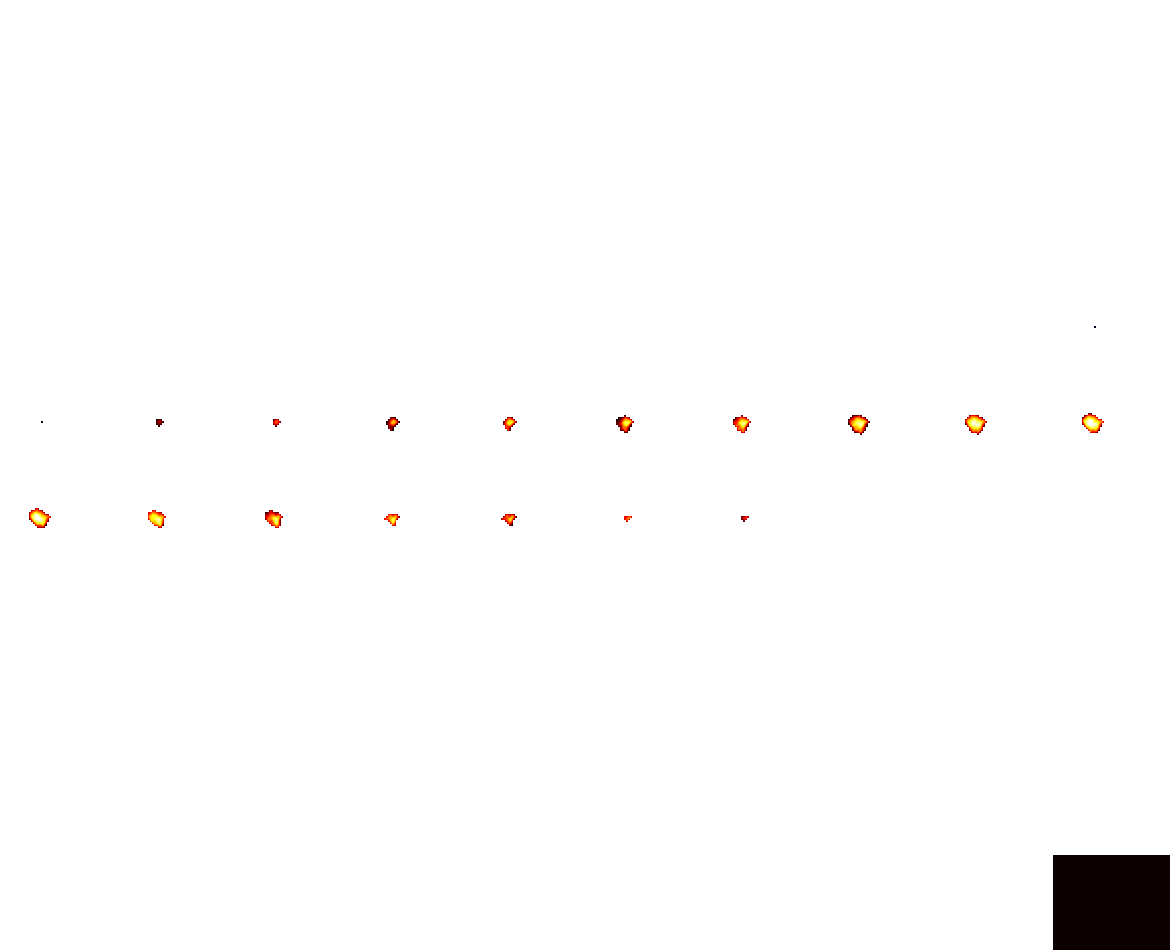

In [85]:
roi_data = np.zeros(39)  
roi_data[4] = 1  

# 使用atlas_masker进行反变换得到Nifti图像
roi_img = atlas_masker.inverse_transform(roi_data)

# 使用view_img查看这个ROI
view_img(roi_img,  title="5th ROI of the Atlas")

/Users/xuan/anaconda3/envs/tuto/lib/python3.8/site-packages/numpy/ma/core.py:2826: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/xuan/anaconda3/envs/tuto/lib/python3.8/site-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/xuan/anaconda3/envs/tuto/lib/python3.8/site-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/Users/xuan/anaconda3/envs/tuto/lib/python3.8/site-packages/nilearn/plotting/displays/_axes.py:74: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(


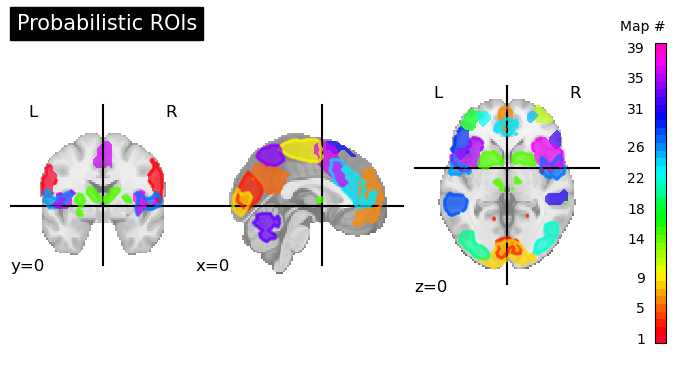

In [99]:
plot_prob_atlas(atlas_filepath, title="Probabilistic ROIs", display_mode='ortho', cut_coords=(0,0,0), view_type='filled_contours', colorbar=True)

shape of single_time_point_img: (50, 59, 50)


/Users/xuan/anaconda3/envs/tuto/lib/python3.8/site-packages/nilearn/plotting/html_stat_map.py:112: UserWarning: Threshold given was 1e-06, but the data has no values below -121.83067321777344. 
  warnings.warn(
/Users/xuan/anaconda3/envs/tuto/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/xuan/anaconda3/envs/tuto/lib/python3.8/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



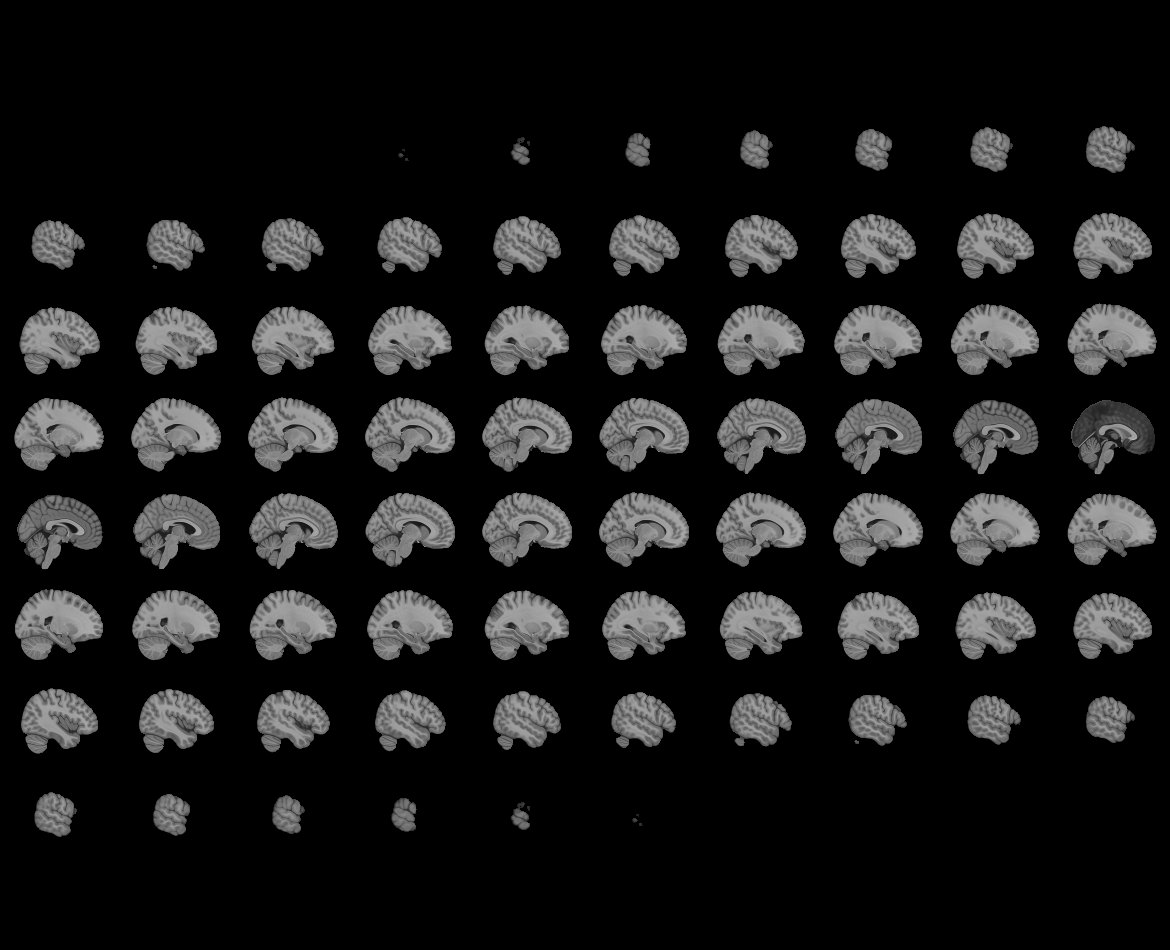
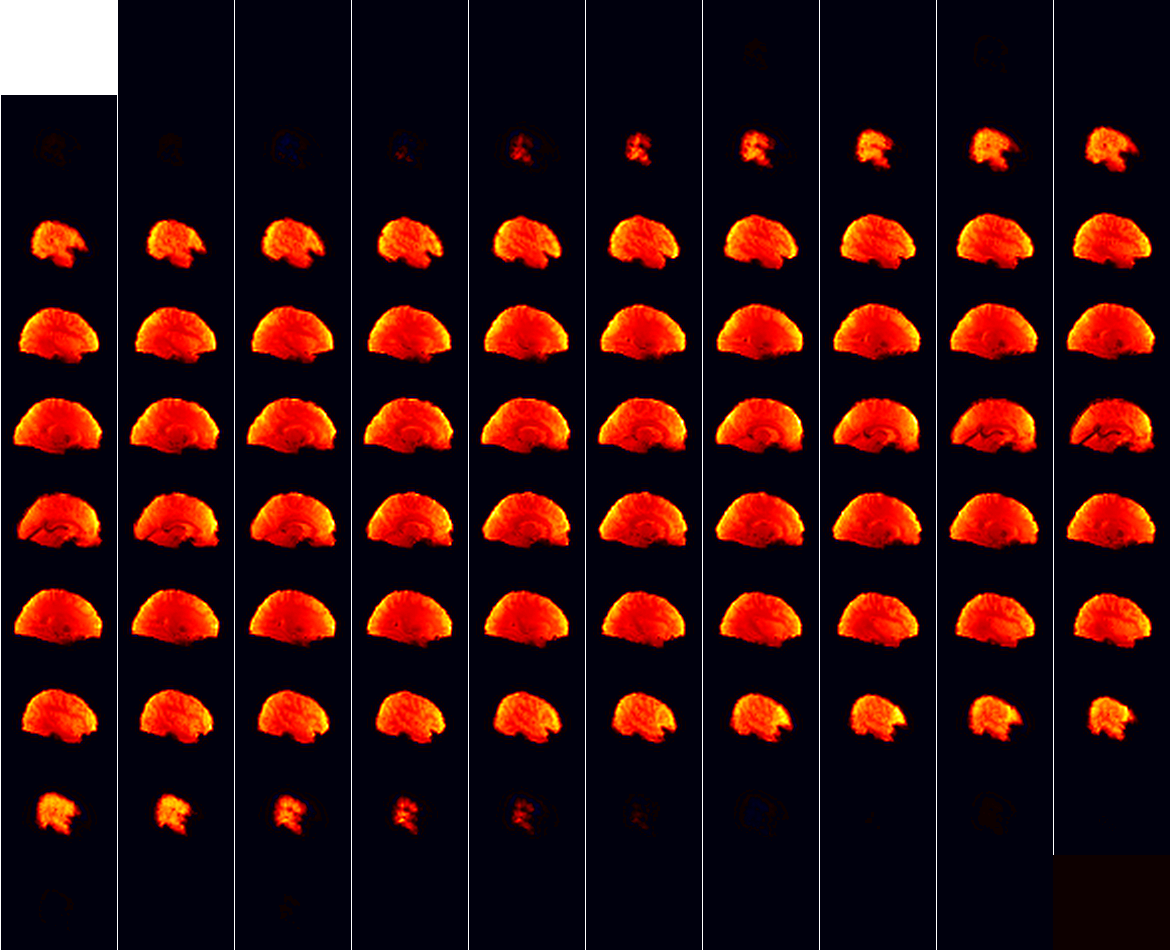

In [104]:
# 假设 fmri_img 是一个4D Nifti图像
# 提取第84个时间点（索引为83）
single_time_point_img = fmri_img.slicer[:,:,:,83]

print(f"shape of single_time_point_img: {single_time_point_img.shape}")

# 使用 view_img 查看这个时间点的图像
view_img(single_time_point_img, title="84th Time Point")


## 3. Seed-based connectivity

* Using the information provided in [this nilearn tutorial](https://nilearn.github.io/stable/auto_examples/03_connectivity/plot_seed_to_voxel_correlation.html), plot the seed-to-voxel correlation map of our fmri_img for the seed of coordinates (-16, -74, 7) and with a sphere mask of radius of size 10. 

In [150]:
from nilearn.input_data import NiftiSpheresMasker
from nilearn.plotting import plot_stat_map

In [159]:
type(data)

sklearn.utils._bunch.Bunch

In [112]:
data

{'func': ['../data/connectivity/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'],
 'confounds': ['../data/connectivity/development_fmri/development_fmri/sub-pixar123_task-pixar_desc-reducedConfounds_regressors.tsv'],
 'phenotypic': array([('sub-pixar123', 27.06, 'Adult', 'adult', 'F', 'R')],
       dtype=[('participant_id', '<U12'), ('Age', '<f8'), ('AgeGroup', '<U6'), ('Child_Adult', '<U5'), ('Gender', '<U4'), ('Handedness', '<U4')]),
 'description': ".. _development_dataset:\n\ndevelopment fMRI dataset\n========================\n\nAccess\n------\nSee :func:`nilearn.datasets.fetch_development_fmri`.\n\nNotes\n-----\nThis movie-watching based functional MRI dataset is used for teaching how to use\nmachine learning to predict age from naturalistic stimuli (movie)\nwatching with Nilearn.\n\nThe dataset consists of 50 children (ages 3-13) and 33 young adults (ages\n18-39). This dataset can be used to try to predict who are adul

In [160]:
type(fmri_filepath)

str

In [111]:
fmri_filepath

'../data/connectivity/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'

In [161]:
type(fmri_img)

nibabel.nifti1.Nifti1Image

In [113]:
fmri_img

In [162]:
type(fmri_data)

numpy.ndarray

In [114]:
fmri_data

array([[[[-0.51120853, -0.51120853, -0.51120853, ..., -0.51120853,
          -0.51120853, -0.51120853],
         [-0.51120853, -0.51120853, -0.51120853, ..., -0.51120853,
          -0.51120853, -0.51120853],
         [-0.51120853, -0.51120853, -0.51120853, ..., -0.51120853,
          -0.51120853, -0.51120853],
         ...,
         [-0.51120853, -0.51120853, -0.51120853, ..., -0.51120853,
          -0.51120853, -0.51120853],
         [-0.51120853, -0.51120853, -0.51120853, ..., -0.51120853,
          -0.51120853, -0.51120853],
         [-0.51120853, -0.51120853, -0.51120853, ..., -0.51120853,
          -0.51120853, -0.51120853]],

        [[-0.51120853, -0.51120853, -0.51120853, ..., -0.51120853,
          -0.51120853, -0.51120853],
         [-0.51120853, -0.51120853, -0.51120853, ..., -0.51120853,
          -0.51120853, -0.51120853],
         [-0.51120853, -0.51120853, -0.51120853, ..., -0.51120853,
          -0.51120853, -0.51120853],
         ...,
         [-0.51120853, -0.51120853

In [119]:
masker_try = NiftiMasker()
masked_data_try = masker_try.fit_transform(fmri_filepath)
print(masked_data_try.shape)
print(masked_data_try)

(168, 32504)
[[ 5.26590872  5.26590872  5.26590872 ... -6.28832579 -0.51120853
  -6.28832579]
 [ 5.26590872  5.26590872  5.26590872 ... -6.28832579 -0.51120853
  -6.28832579]
 [ 5.26590872  5.26590872  5.26590872 ... -6.28832579 -0.51120853
  -6.28832579]
 ...
 [ 5.26590872  5.26590872  5.26590872 ... -6.28832579 -0.51120853
  -6.28832579]
 [ 5.26590872  5.26590872  5.26590872 ... -6.28832579 -0.51120853
  -6.28832579]
 [ 5.26590872  5.26590872  5.26590872 ... -6.28832579 -0.51120853
  -6.28832579]]


In [120]:
masked_data_try2 = masker_try.fit_transform(fmri_img)
print(masked_data_try2.shape)
print(masked_data_try2)

(168, 32504)
[[ 5.26590872  5.26590872  5.26590872 ... -6.28832579 -0.51120853
  -6.28832579]
 [ 5.26590872  5.26590872  5.26590872 ... -6.28832579 -0.51120853
  -6.28832579]
 [ 5.26590872  5.26590872  5.26590872 ... -6.28832579 -0.51120853
  -6.28832579]
 ...
 [ 5.26590872  5.26590872  5.26590872 ... -6.28832579 -0.51120853
  -6.28832579]
 [ 5.26590872  5.26590872  5.26590872 ... -6.28832579 -0.51120853
  -6.28832579]
 [ 5.26590872  5.26590872  5.26590872 ... -6.28832579 -0.51120853
  -6.28832579]]


/Users/xuan/anaconda3/envs/tuto/lib/python3.8/site-packages/nilearn/plotting/html_stat_map.py:112: UserWarning: Threshold given was 1e-06, but the data has no values below -116.0191650390625. 
  warnings.warn(
/Users/xuan/anaconda3/envs/tuto/lib/python3.8/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/xuan/anaconda3/envs/tuto/lib/python3.8/site-packages/nilearn/plotting/html_document.py:102: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn(



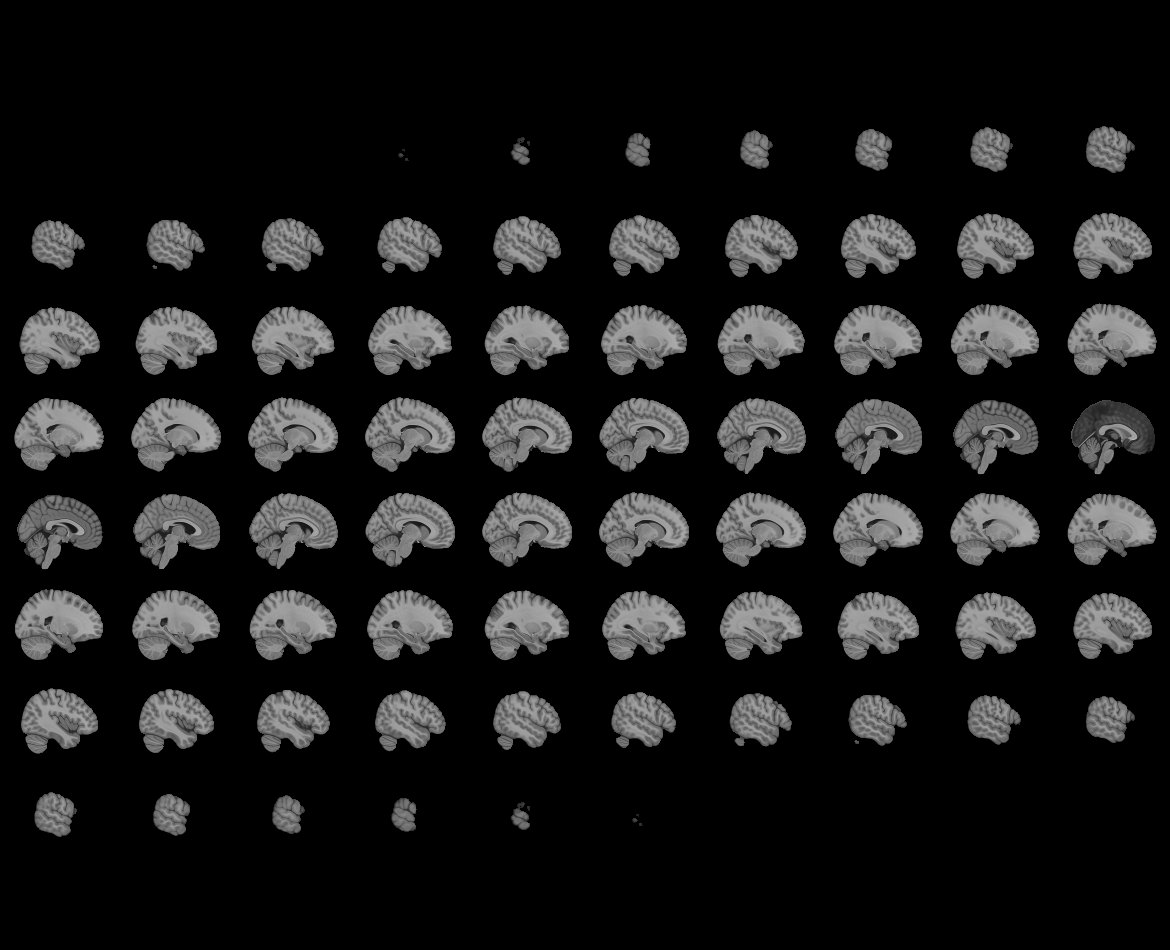
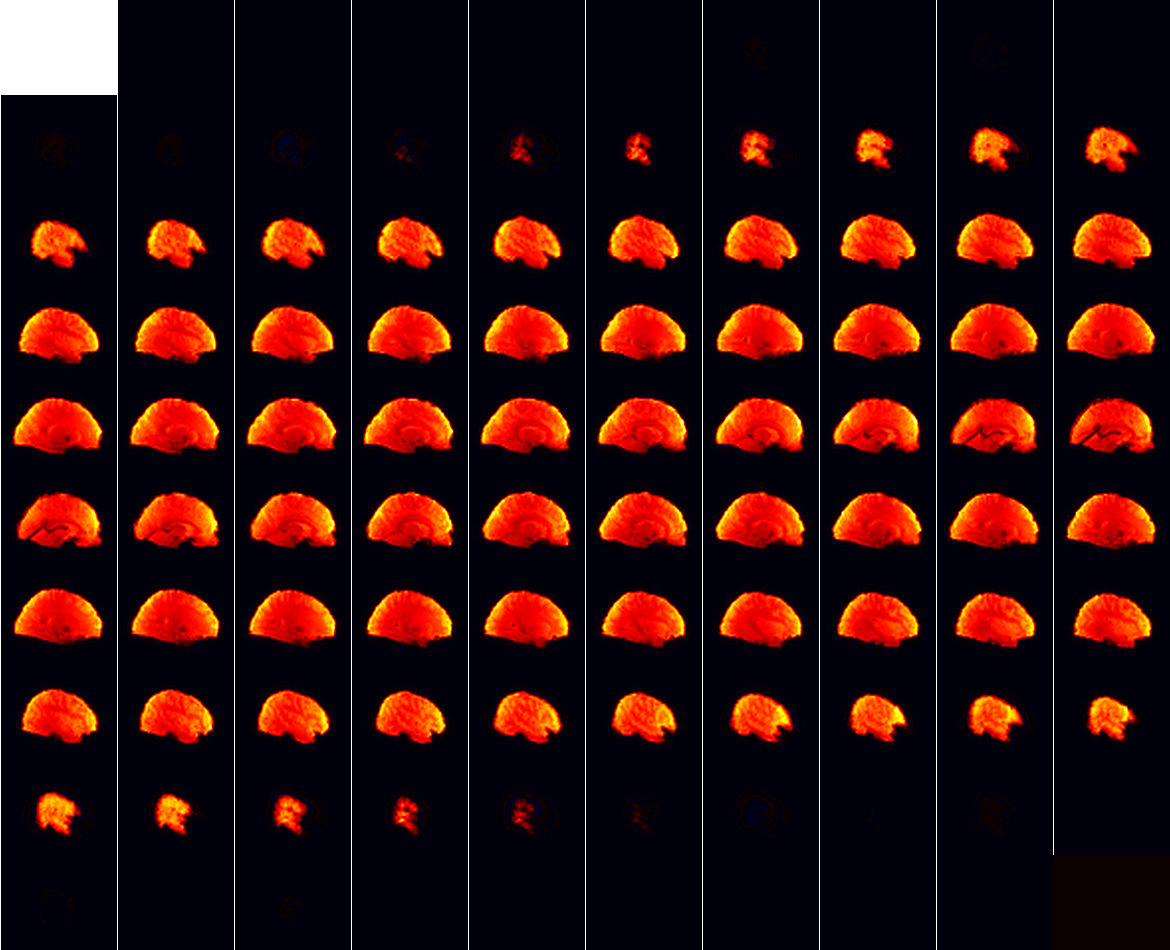

In [121]:
mean_fmri_img = mean_img(fmri_img)
view_img(mean_fmri_img)

In [138]:
vis_coords = [(-16, -74, 7)]

mask_img = datasets.load_mni152_brain_mask()

sphere_masker = NiftiSpheresMasker(
    seeds=vis_coords,
    radius=10,
    detrend=True,
    standardize=True,
    smoothing_fwhm=6,
    memory='nilearn_cache',
    memory_level=1,
    verbose=0,
    mask_img=mask_img  # 添加掩膜图像
)

In [143]:
sphere_masker.fit(fmri_img)

NiftiSpheresMasker(detrend=True,
                   mask_img=<nibabel.nifti1.Nifti1Image object at 0x177520160>,
                   memory=Memory(location=nilearn_cache/joblib), radius=10,
                   seeds=[(-16, -74, 7)], smoothing_fwhm=6, standardize=True)

In [144]:
seed_time_series = sphere_masker.transform(fmri_img)

In [147]:
seed_time_series.shape

(168, 1)

In [146]:
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([seed_time_series])[0]
correlation_matrix.shape

(1, 1)

In [148]:
correlation_img = sphere_masker.inverse_transform(correlation_matrix)

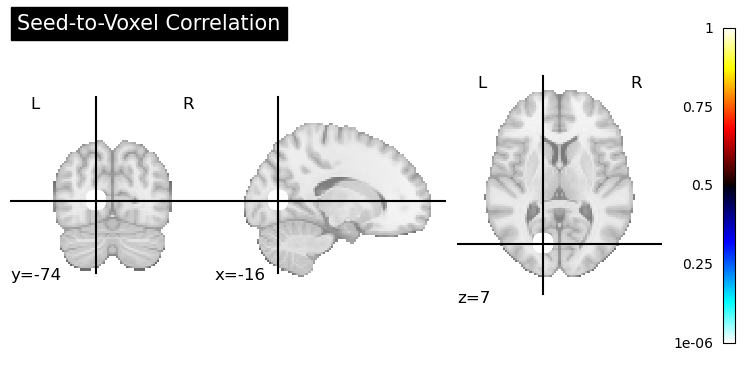

In [158]:
display = plot_stat_map(
    correlation_img,
    display_mode='ortho',
    cut_coords=vis_coords[0],
    title="Seed-to-Voxel Correlation"
)